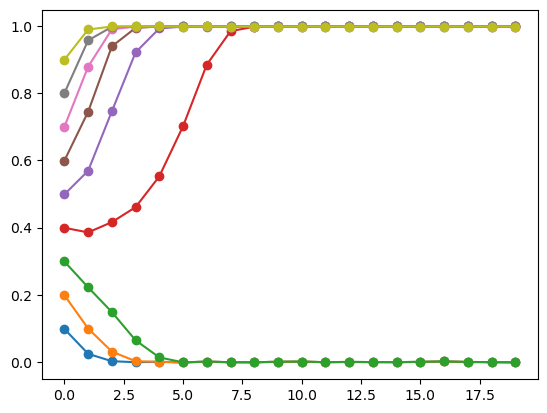

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, pi, exp
from scipy.special import erf

fig, ax = plt.subplots()

T = 20
Nex = 10**6
alpha = 0.05

Nsamp = 1

m0_list = [0.1*n for n in range(1,10)]

rng = np.random.RandomState(seed=1)



#### 理論
for m0 in m0_list:
    m_list_list = []
    rng = np.random.RandomState(seed=2)
    for nsamp in range(Nsamp):
        Q = np.zeros((T+1,T+1)) # x の２時刻相関
        S = np.zeros((T+1,T+1)) # s と ik の２時刻相関

        x = np.zeros((T+1,Nex))
        h = np.zeros((T+1,Nex))
        g1 = rng.standard_normal((T+1,Nex))
        g2 = rng.standard_normal((T+1,))
        phi = np.zeros((T+1,Nex))
        z = np.zeros((T+1,))

        x[0,:] = np.ones((Nex,))
        for i in range(Nex):
            if rng.random() > (1+m0)/2:
                x[0,i] *= (-1)
        phi[0,:] = np.sqrt(alpha/2)*g1[0,:].copy() # Rh[0,0] = alpha/2
        z[0] = np.sqrt(alpha/Nex)*g2[0].copy() # alpha/Nex*Q[0,0] = alpha/Nex
        
        h[0,:] = x[0,:].mean()**2 /2 + phi[0,:].copy() -z[0].copy()*x[0,:] -1/Nex/2- x[0,:].mean()**2/Nex+1/Nex**2
        x[1,:] = np.sign(h[0,:])


        Q[0,0] = 1
        Q[0,1] = (x[0,:]*x[1,:]).mean()
        Q[1,0] = Q[0,1]
        Q[1,1] = 1

        S[0,0] = 0
        S[0,1] = 0
        #S[1,0] = 0       
        S[1,0] = -2/sqrt(alpha*pi)*exp(-(x[0,:].mean())**4/(4*alpha))
        S[1,1] = 0

        m_list = [x[0,:].mean()]
        for t in range(1,T):
            m = x[t,:].mean()
            m_list.append(m)
    
            Rh = alpha/2 * Q[:t+1,:t+1]**2 # ノイズの共分散行列の評価    

            [D,U] = np.linalg.eigh(Rh) # 固有値の桁落ちへの対応
            if min(D) < 1.0e-8: 
                Rh = Rh + (1.0e-8-min(D))*np.eye(t+1)
            L = np.linalg.cholesky(Rh) # 共分散行列をコレスキー分解
            phi[:t+1,:] = L@g1[:t+1,:] # 相関のあるガウス乱数の発生
            Sh = alpha*Q[:t+1,:t+1]*S[:t+1,:t+1].T # 応答関数
            [D2,U2] = np.linalg.eigh(Q[:t+1,:t+1]) # 固有値の桁落ちへの対応
            if min(D2) < 1.0e-8: 
                 Q[:t+1,:t+1] = Q[:t+1,:t+1] + (1.0e-8-min(D2))*np.eye(t+1)
            L2 = np.linalg.cholesky(Q[:t+1,:t+1]) # 共分散行列をコレスキー分解
            z[:t+1] = np.sqrt(alpha/Nex)*L2 @g2[:t+1]

            h[t,:] = x[t,:].mean()**2 /2  + phi[t,:] - (Sh[:,t])@x[:t+1,:] 
            #-alpha/2 * x[t,:] * np.sum(S[t,:t]) 
            #+  x[t,:] * z[t]   # 局所場の評価
            x[t+1,:]= np.sign(h[t,:]) # 次時刻の変数
            Q[:t+2,:t+2] = (x[:t+2,:]@x[:t+2,:].T)/Nex
    
            xphi = (x[t+1,:]*phi[:t+1,:]).mean(axis = 1) # [x phi] の平均
            S[t+1,:t+1] = -np.linalg.inv(Rh)@xphi # [\partial x/\partial \phi] = -[x ik] の評価
    
        m_list_list.append(m_list)

    m_array = np.array(m_list_list)

    
    ax.plot([n for n in range(int(T))], m_array.mean(axis=0), marker = 'o')